In [65]:
import csv
import pandas as pd
import numpy as np
import seaborn
from seaborn import pairplot
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv('cleaner_data.csv')
df.head()


,Unnamed: 0,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,def_pass_epa_home,def_rush_epa_home,def_epa_away,def_pass_epa_away,def_rush_epa_away
0,1,2011_01_ATL_CHI,2011,1,CHI,Jay Cutler,-0.055269,ATL,Matt Ryan,-0.262554,-0.262554,-0.290874,-0.166269,-0.055269,0.014545,-0.150940
1,2,2011_01_BUF_KC,2011,1,KC,Matt Cassel,-0.372663,BUF,Ryan Fitzpatrick,0.223898,0.223898,0.443865,0.067607,-0.372663,-0.444717,-0.220548
2,3,2011_01_CAR_ARI,2011,1,ARI,Kevin Kolb,0.132567,CAR,Cam Newton,0.125934,0.125934,0.348553,-0.212117,0.132567,0.395432,-0.198872
3,4,2011_01_CIN_CLE,2011,1,CLE,Colt McCoy,-0.150630,CIN,Andy Dalton,0.054779,0.054779,-0.018311,0.127870,-0.150630,-0.214656,-0.043065
4,5,2011_01_DAL_NYJ,2011,1,NYJ,Mark Sanchez,-0.071235,DAL,Tony Romo,0.050997,0.050997,0.200578,-0.188334,-0.071235,-0.027524,-0.202369


In [67]:
data = df[['game_id','season','week','home_team','home_qb_name','home_off_epa','away_team','away_qb_name','away_off_epa','def_epa_home','def_epa_away']]

In [68]:
games_df = pd.read_csv('ML_epa_data.csv')
games_df.head()

,Unnamed: 0,game_id,total_line,spread_line,home_score,away_score,result,total,season,week,home_team,away_team,posteam,defteam,off_epa,off_pass_epa,off_rush_epa,def_epa,def_pass_epa,def_rush_epa
0,1,2011_01_NO_GB,47.5,-4.5,42.0,34.0,-8.0,76.0,2011.0,1.0,GB,NO,GB,NO,0.355356,0.554186,0.072405,0.160695,0.275887,-0.119056
1,2,2011_01_NO_GB,47.5,-4.5,42.0,34.0,-8.0,76.0,2011.0,1.0,GB,NO,NO,GB,0.160695,0.275887,-0.119056,0.355356,0.554186,0.072405
2,3,2011_01_PIT_BAL,37.0,-1.0,35.0,7.0,-28.0,42.0,2011.0,1.0,BAL,PIT,BAL,PIT,0.184658,0.345858,0.033533,-0.341011,-0.378989,-0.234197
3,4,2011_01_PIT_BAL,37.0,-1.0,35.0,7.0,-28.0,42.0,2011.0,1.0,BAL,PIT,PIT,BAL,-0.341011,-0.378989,-0.234197,0.184658,0.345858,0.033533
4,5,2011_01_ATL_CHI,40.5,1.0,30.0,12.0,-18.0,42.0,2011.0,1.0,CHI,ATL,ATL,CHI,-0.262554,-0.290874,-0.166269,-0.055269,0.014545,-0.150940


In [69]:
schedule = games_df[['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score','spread_line','total_line', 'total']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))
schedule.head()

,game_id,season,week,home_team,away_team,home_score,away_score,spread_line,total_line,total,home_team_win
0,2011_01_NO_GB,2011.0,1.0,GB,NO,42.0,34.0,-4.5,47.5,76.0,1
1,2011_01_PIT_BAL,2011.0,1.0,BAL,PIT,35.0,7.0,-1.0,37.0,42.0,1
2,2011_01_ATL_CHI,2011.0,1.0,CHI,ATL,30.0,12.0,1.0,40.5,42.0,1
3,2011_01_CIN_CLE,2011.0,1.0,CLE,CIN,17.0,27.0,-6.5,36.5,44.0,0
4,2011_01_IND_HOU,2011.0,1.0,HOU,IND,34.0,7.0,-9.0,44.0,41.0,1


In [73]:
test_df = data.merge(schedule, on =['game_id','season','week','home_team','away_team'])
test_df.head()

,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,def_epa_away,home_score,away_score,spread_line,total_line,total,home_team_win
0,2011_01_ATL_CHI,2011,1,CHI,Jay Cutler,-0.055269,ATL,Matt Ryan,-0.262554,-0.262554,-0.055269,30.0,12.0,1.0,40.5,42.0,1
1,2011_01_BUF_KC,2011,1,KC,Matt Cassel,-0.372663,BUF,Ryan Fitzpatrick,0.223898,0.223898,-0.372663,7.0,41.0,-3.5,38.5,48.0,0
2,2011_01_CAR_ARI,2011,1,ARI,Kevin Kolb,0.132567,CAR,Cam Newton,0.125934,0.125934,0.132567,28.0,21.0,-6.5,37.5,49.0,1
3,2011_01_CIN_CLE,2011,1,CLE,Colt McCoy,-0.150630,CIN,Andy Dalton,0.054779,0.054779,-0.150630,17.0,27.0,-6.5,36.5,44.0,0
4,2011_01_DAL_NYJ,2011,1,NYJ,Mark Sanchez,-0.071235,DAL,Tony Romo,0.050997,0.050997,-0.071235,27.0,24.0,-6.5,40.5,51.0,1


shift epas / average epas

In [74]:
test_df['home_qb_epa_shifted'] = test_df.groupby('home_qb_name')['home_off_epa'].shift()
test_df['away_qb_epa_shifted'] = test_df.groupby('away_qb_name')['away_off_epa'].shift()
test_df['home_def_shifted'] = test_df.groupby('home_team')['def_epa_home'].shift()
test_df['away_def_shifted'] = test_df.groupby('away_team')['def_epa_away'].shift()

test_df.head()


,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,...,home_score,away_score,spread_line,total_line,total,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted
0,2011_01_ATL_CHI,2011,1,CHI,Jay Cutler,-0.055269,ATL,Matt Ryan,-0.262554,-0.262554,...,30.0,12.0,1.0,40.5,42.0,1,NaN,NaN,NaN,NaN
1,2011_01_BUF_KC,2011,1,KC,Matt Cassel,-0.372663,BUF,Ryan Fitzpatrick,0.223898,0.223898,...,7.0,41.0,-3.5,38.5,48.0,0,NaN,NaN,NaN,NaN
2,2011_01_CAR_ARI,2011,1,ARI,Kevin Kolb,0.132567,CAR,Cam Newton,0.125934,0.125934,...,28.0,21.0,-6.5,37.5,49.0,1,NaN,NaN,NaN,NaN
3,2011_01_CIN_CLE,2011,1,CLE,Colt McCoy,-0.150630,CIN,Andy Dalton,0.054779,0.054779,...,17.0,27.0,-6.5,36.5,44.0,0,NaN,NaN,NaN,NaN
4,2011_01_DAL_NYJ,2011,1,NYJ,Mark Sanchez,-0.071235,DAL,Tony Romo,0.050997,0.050997,...,27.0,24.0,-6.5,40.5,51.0,1,NaN,NaN,NaN,NaN


In [53]:
test_df['home_qb_ewa'] = test_df.groupby('home_qb_name')['home_qb_epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=5).mean())
test_df['away_qb_ewa'] = test_df.groupby('away_qb_name')['away_qb_epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=5).mean())
test_df['home_def_ewa'] = test_df.groupby('home_team')['home_def_shifted'].transform(lambda x: x.ewm(min_periods=1, span=5).mean())
test_df['away_def_ewa'] = test_df.groupby('away_team')['away_def_shifted'].transform(lambda x: x.ewm(min_periods=1, span=5).mean())
test_df


,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,...,total,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted,home_qb_ewa,away_qb_ewa,home_def_ewa,away_def_ewa
0,2011_01_ATL_CHI,2011,1,CHI,Jay Cutler,-0.055269,ATL,Matt Ryan,-0.262554,-0.262554,...,42.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011_01_BUF_KC,2011,1,KC,Matt Cassel,-0.372663,BUF,Ryan Fitzpatrick,0.223898,0.223898,...,48.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011_01_CAR_ARI,2011,1,ARI,Kevin Kolb,0.132567,CAR,Cam Newton,0.125934,0.125934,...,49.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011_01_CIN_CLE,2011,1,CLE,Colt McCoy,-0.150630,CIN,Andy Dalton,0.054779,0.054779,...,44.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011_01_DAL_NYJ,2011,1,NYJ,Mark Sanchez,-0.071235,DAL,Tony Romo,0.050997,0.050997,...,51.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2021_10_MIN_LAC,2021,10,LAC,Justin Herbert,-0.124359,MIN,Kirk Cousins,0.134792,0.134792,...,47.0,0,-0.028938,0.173613,-0.029235,0.105277,0.068089,0.146844,0.039136,0.025332
2818,2021_10_NO_TEN,2021,10,TEN,Ryan Tannehill,-0.066429,NO,Trevor Siemian,0.111866,0.111866,...,44.0,1,0.189013,0.217527,-0.100877,-0.122105,0.107299,-0.118052,0.036425,-0.157979
2819,2021_10_PHI_DEN,2021,10,DEN,Teddy Bridgewater,-0.260955,PHI,Jalen Hurts,0.134323,0.134323,...,43.0,0,0.078866,0.233459,-0.016824,-0.405132,-0.040730,0.040595,0.057669,-0.118038
2820,2021_10_SEA_GB,2021,10,GB,Aaron Rodgers,0.064245,SEA,Russell Wilson,-0.303277,-0.303277,...,17.0,1,0.093420,-0.069162,-0.104424,0.000655,0.141187,0.040521,-0.059460,0.043662


In [76]:
test_df = test_df.fillna(test_df.mean())
test_df

,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,...,home_score,away_score,spread_line,total_line,total,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted
0,2011_01_ATL_CHI,2011,1,CHI,Jay Cutler,-0.055269,ATL,Matt Ryan,-0.262554,-0.262554,...,30.0,12.0,1.0,40.5,42.0,1,-0.001121,0.006462,-0.000574,-0.007464
1,2011_01_BUF_KC,2011,1,KC,Matt Cassel,-0.372663,BUF,Ryan Fitzpatrick,0.223898,0.223898,...,7.0,41.0,-3.5,38.5,48.0,0,-0.001121,0.006462,-0.000574,-0.007464
2,2011_01_CAR_ARI,2011,1,ARI,Kevin Kolb,0.132567,CAR,Cam Newton,0.125934,0.125934,...,28.0,21.0,-6.5,37.5,49.0,1,-0.001121,0.006462,-0.000574,-0.007464
3,2011_01_CIN_CLE,2011,1,CLE,Colt McCoy,-0.150630,CIN,Andy Dalton,0.054779,0.054779,...,17.0,27.0,-6.5,36.5,44.0,0,-0.001121,0.006462,-0.000574,-0.007464
4,2011_01_DAL_NYJ,2011,1,NYJ,Mark Sanchez,-0.071235,DAL,Tony Romo,0.050997,0.050997,...,27.0,24.0,-6.5,40.5,51.0,1,-0.001121,0.006462,-0.000574,-0.007464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2021_10_MIN_LAC,2021,10,LAC,Justin Herbert,-0.124359,MIN,Kirk Cousins,0.134792,0.134792,...,20.0,27.0,-3.0,53.5,47.0,0,-0.028938,0.173613,-0.029235,0.105277
2818,2021_10_NO_TEN,2021,10,TEN,Ryan Tannehill,-0.066429,NO,Trevor Siemian,0.111866,0.111866,...,23.0,21.0,-3.0,44.0,44.0,1,0.189013,0.217527,-0.100877,-0.122105
2819,2021_10_PHI_DEN,2021,10,DEN,Teddy Bridgewater,-0.260955,PHI,Jalen Hurts,0.134323,0.134323,...,13.0,30.0,-1.0,44.5,43.0,0,0.078866,0.233459,-0.016824,-0.405132
2820,2021_10_SEA_GB,2021,10,GB,Aaron Rodgers,0.064245,SEA,Russell Wilson,-0.303277,-0.303277,...,17.0,0.0,-3.0,49.5,17.0,1,0.093420,-0.069162,-0.104424,0.000655


In [54]:
# remove the first season 
ml = test_df.loc[test_df['season'] != test_df['season'].unique()[0], :]

ml = ml.reset_index(drop=True)

ml.head()

,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,...,total,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted,home_qb_ewa,away_qb_ewa,home_def_ewa,away_def_ewa
0,2012_01_ATL_KC,2012,1,KC,Matt Cassel,0.100970,ATL,Matt Ryan,0.375781,0.375781,...,64.0,0,-0.169131,-0.212683,-0.061902,0.245485,-0.150101,-0.059746,0.017354,0.121941
1,2012_01_BUF_NYJ,2012,1,NYJ,Mark Sanchez,0.277928,BUF,Ryan Fitzpatrick,0.143898,0.143898,...,76.0,1,-0.208837,-0.072235,-0.037124,0.296439,-0.072555,-0.129389,-0.076929,0.194386
2,2012_01_CAR_TB,2012,1,TB,Josh Freeman,-0.091789,CAR,Cam Newton,-0.077471,-0.077471,...,26.0,1,-0.213490,0.020863,0.266145,0.459369,-0.214062,0.137001,0.218705,0.146984
3,2012_01_CIN_BAL,2012,1,BAL,Joe Flacco,0.303746,CIN,Andy Dalton,-0.158178,-0.158178,...,57.0,1,-0.225808,-0.190411,-0.095524,0.161668,-0.074411,-0.090996,-0.156131,0.026048
4,2012_01_DAL_NYG,2012,1,NYG,Eli Manning,-0.012447,DAL,Tony Romo,0.275412,0.275412,...,41.0,0,0.245485,-0.126184,-0.212683,0.187463,0.101621,0.031607,-0.052681,0.047419


In [77]:
ml.columns

Index(['game_id', 'season', 'week', 'home_team', 'home_qb_name',
       'home_off_epa', 'away_team', 'away_qb_name', 'away_off_epa',
       'def_epa_home', 'def_epa_away', 'home_score', 'away_score',
       'spread_line', 'total_line', 'total', 'home_team_win',
       'home_qb_epa_shifted', 'away_qb_epa_shifted', 'home_def_shifted',
       'away_def_shifted', 'home_qb_ewa', 'away_qb_ewa', 'home_def_ewa',
       'away_def_ewa'],
      dtype='object')

In [78]:
target = 'home_team_win'
features = [column for column in ml.columns if 'ewa' in column]
for feature in features:
  print(feature)

home_qb_ewa
away_qb_ewa
home_def_ewa
away_def_ewa


In [79]:
ml = ml.dropna()

X = ml.loc[df['season'] != 2021, features].values
y = ml.loc[df['season'] != 2021, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [80]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.6122394518571944


In [81]:
print('Neg log loss:', np.mean(log_losses))

Neg log loss: -0.6591413669566422



# Below is how the simulation has performed so far this nfl season

In [82]:
data_2021 = ml.loc[(ml['season'] == 2021)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

data_2021['actual_winner'] = data_2021.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
data_2021['predicted_winner'] = data_2021.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
data_2021['win_probability'] = data_2021.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
data_2021['correct_prediction'] = (data_2021['predicted_winner'] == data_2021['actual_winner']).astype(int)

data_2021 = data_2021.drop(columns=['home_team_win_probability', 'home_team_win'])

data_2021.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(20)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,IND,HOU,6,IND,IND,0.904131,1
1,LV,CHI,5,LV,CHI,0.876201,0
2,ARI,HOU,7,ARI,ARI,0.837322,1
3,TB,CHI,7,TB,TB,0.821196,1
4,DET,SF,1,SF,SF,0.808763,1
5,BUF,MIA,8,BUF,BUF,0.765639,1
6,PIT,CHI,9,PIT,PIT,0.752847,1
7,GB,PIT,4,GB,GB,0.729869,1
8,ATL,NYJ,5,ATL,ATL,0.723415,1
9,JAX,ARI,3,ARI,ARI,0.714629,1


In [86]:
corr = ml.corr()
corr

,season,week,home_off_epa,away_off_epa,def_epa_home,def_epa_away,home_score,away_score,spread_line,total_line,total,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted,home_qb_ewa,away_qb_ewa,home_def_ewa,away_def_ewa
season,1.000000,-0.080137,0.014038,0.066742,0.066742,0.014038,-0.017952,0.065475,0.051385,0.160087,0.033149,-0.052169,0.010105,0.054272,0.064426,0.008587,-0.003614,0.075710,0.104258,0.002082
week,-0.080137,1.000000,-0.014077,-0.044347,-0.044347,-0.014077,-0.000333,-0.039215,-0.014131,-0.023799,-0.027989,0.007354,0.021696,0.000912,-0.048442,-0.100553,0.028328,0.008137,-0.042584,-0.082773
home_off_epa,0.014038,-0.014077,1.000000,0.035991,0.035991,1.000000,0.755004,-0.158395,-0.302715,0.229293,0.442038,0.508513,0.131036,-0.006191,-0.008022,0.060921,0.225735,-0.030143,-0.003373,0.110676
away_off_epa,0.066742,-0.044347,0.035991,1.000000,1.000000,0.035991,-0.179904,0.770415,0.283522,0.238718,0.413047,-0.502697,0.022145,0.141224,0.120222,-0.002046,0.006421,0.215939,0.174429,0.002833
def_epa_home,0.066742,-0.044347,0.035991,1.000000,1.000000,0.035991,-0.179904,0.770415,0.283522,0.238718,0.413047,-0.502697,0.022145,0.141224,0.120222,-0.002046,0.006421,0.215939,0.174429,0.002833
def_epa_away,0.014038,-0.014077,1.000000,0.035991,0.035991,1.000000,0.755004,-0.158395,-0.302715,0.229293,0.442038,0.508513,0.131036,-0.006191,-0.008022,0.060921,0.225735,-0.030143,-0.003373,0.110676
home_score,-0.017952,-0.000333,0.755004,-0.179904,-0.179904,0.755004,1.000000,-0.037747,-0.326377,0.198898,0.707203,0.563781,0.119807,-0.056367,-0.018826,0.029286,0.203640,-0.084232,-0.026428,0.072331
away_score,0.065475,-0.039215,-0.158395,0.770415,0.770415,-0.158395,-0.037747,1.000000,0.288456,0.207892,0.679812,-0.557449,0.008326,0.109265,0.099189,-0.020567,-0.023807,0.176834,0.142519,-0.030391
spread_line,0.051385,-0.014131,-0.302715,0.283522,0.283522,-0.302715,-0.326377,0.288456,1.000000,-0.012327,-0.035445,-0.370126,-0.260975,0.221935,0.173736,-0.111924,-0.414018,0.353437,0.268440,-0.211858
total_line,0.160087,-0.023799,0.229293,0.238718,0.238718,0.229293,0.198898,0.207892,-0.012327,1.000000,0.293059,-0.038953,0.268199,0.254479,0.162473,0.102804,0.369267,0.369159,0.230644,0.176229


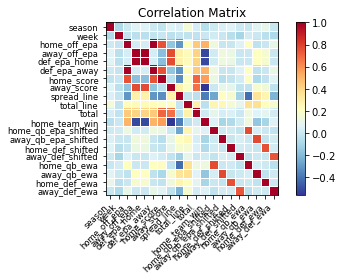

In [87]:
from statsmodels.graphics.correlation import plot_corr

correlation_viz = plot_corr(corr, xnames = corr.columns) 

In [88]:
train, test = train_test_split(ml, test_size=0.2)
lin_reg = LinearRegression()

In [90]:
trained_data = lin_reg.fit(train[['home_qb_ewa','away_qb_ewa']], train[['home_team_win']])

In [91]:
test['pred_home_win'] = trained_data.predict(test[['home_qb_ewa','away_qb_ewa']])

/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
test

,game_id,season,week,home_team,home_qb_name,home_off_epa,away_team,away_qb_name,away_off_epa,def_epa_home,...,home_team_win,home_qb_epa_shifted,away_qb_epa_shifted,home_def_shifted,away_def_shifted,home_qb_ewa,away_qb_ewa,home_def_ewa,away_def_ewa,pred_home_win
575,2014_03_OAK_NE,2014,3,NE,Tom Brady,0.021774,LV,Derek Carr,-0.107611,-0.107611,...,1,0.200770,-0.241542,-0.091801,-0.010333,0.125285,-0.241542,0.015822,0.014287,0.799384
2488,2021_06_DAL_NE,2021,6,NE,Mac Jones,-0.012814,DAL,Dak Prescott,0.161461,0.161461,...,0,-0.083826,0.102904,0.100557,0.094333,-0.118468,0.077154,0.085375,0.029301,0.450986
1646,2018_03_OAK_MIA,2018,3,MIA,Ryan Tannehill,0.339005,LV,Derek Carr,0.072962,0.072962,...,1,-0.045158,0.093030,-0.290421,0.092755,0.005490,-0.100876,-0.135068,0.058146,0.638555
2317,2020_13_DEN_KC,2020,13,KC,Patrick Mahomes,0.166672,DEN,Drew Lock,0.091159,0.091159,...,1,0.255129,-0.316975,0.321949,0.099380,0.225615,-0.172729,0.097089,-0.013428,0.812541
1828,2018_16_BUF_NE,2018,16,NE,Tom Brady,-0.189175,BUF,Josh Allen,-0.345609,-0.345609,...,1,0.128822,0.059978,-0.145016,-0.115056,0.143143,-0.125576,-0.033231,-0.144164,0.734178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,2013_21_SEA_DEN,2013,21,DEN,Peyton Manning,-0.395233,SEA,Russell Wilson,0.211566,0.211566,...,0,0.305039,0.030351,0.137983,-0.484094,0.197826,0.069662,0.087904,-0.232534,0.638623
1040,2015_16_WAS_PHI,2015,16,PHI,Sam Bradford,-0.134497,WAS,Kirk Cousins,0.219927,0.219927,...,0,-0.193706,0.201011,0.296961,0.128047,-0.114840,-0.123578,0.159397,0.102816,0.583811
1974,2019_07_SF_WAS,2019,7,WAS,Case Keenum,-0.284450,SF,Jimmy Garoppolo,-0.069799,-0.069799,...,0,-0.272343,-0.083013,0.133257,-0.585769,-0.107128,0.063993,0.136273,-0.213969,0.466109
993,2015_14_ATL_CAR,2015,14,CAR,Cam Newton,0.259337,ATL,Matt Ryan,-0.369433,-0.369433,...,1,0.098442,0.012002,-0.511289,0.174756,0.029483,0.010685,-0.233135,0.042742,0.579762


<AxesSubplot:>

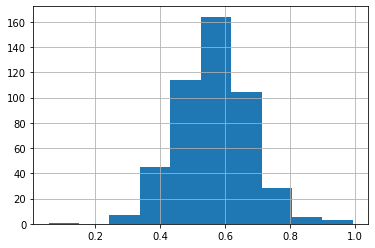

In [93]:
test.pred_home_win.hist()